# Bayesian IGNO: MCMC Posterior Sampling with NumPyro

This notebook implements proper Bayesian inference for inverse problems using IGNO.

## Mathematical Formulation

**Posterior:**
$$p(\beta | u_{obs}) \propto p(u_{obs} | \beta) \cdot p(\beta)$$

**Components:**
- **Likelihood:** $p(u_{obs} | \beta) = \mathcal{N}(u_{obs} | G_{\theta_u}(\beta), \sigma^2 I)$
- **Prior:** $p(\beta)$ from trained normalizing flow
- **Optional PDE term:** $p(R=0 | \beta)$ (disabled initially)

**Potential Energy:**
$$U(\beta) = \frac{1}{2\sigma^2} ||u_{obs} - G_{\theta_u}(\beta)||^2 - \log p_{NF}(\beta)$$

## 1. Setup

In [1]:
import load_this_before_everything_else
import jax
import jax.numpy as jnp
from jax import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

numpyro.set_host_device_count(1)

from src.problems.darcy_continuous import DarcyContinuous, mollifier

print(f"JAX: {jax.__version__}")
print(f"NumPyro: {numpyro.__version__}")
print(f"Devices: {jax.devices()}")

HIGH PRECISION MODE ACTIVATED!!!
JAX: 0.4.26
NumPyro: 0.19.0
Devices: [cuda(id=0)]


## 2. Load Model

In [2]:
# Configuration - MODIFY THESE PATHS
CHECKPOINT_PATH = Path("./runs/8_dims/weights/best.pt")
TRAIN_DATA_PATH = "./data/darcy_continuous/smh_train.mat"
TEST_DATA_PATH = "./data/darcy_continuous/smh_test_in.mat"

# Initialize
problem = DarcyContinuous(
    seed=42,
    train_data_path=TRAIN_DATA_PATH,
    test_data_path=TEST_DATA_PATH,
)

# Load checkpoint
problem.load_checkpoint(CHECKPOINT_PATH)
params = problem.params  # Freeze

print(f"Latent dim: {problem.BETA_SIZE}")

Loading data...
  Train: a=(1000, 841, 1), u=(1000, 841, 1)
  Test: a=(200, 841, 1), u=(200, 841, 1)
Setting up grids and test functions...
  int_grid: (45, 2), v: (45, 1)
Building models...
Problem initialized (parameters not yet initialized)
Loading checkpoint: runs/8_dims/weights/best.pt
  Loaded enc
  Loaded u
  Loaded a
  Loaded nf
Latent dim: 8


## 3. Setup Observations

In [3]:
# Test sample config
TEST_IDX = 0
N_OBS = 100

# Get data
test_data = problem.get_test_data()
a_true = test_data['a'][TEST_IDX:TEST_IDX+1]
u_true = test_data['u'][TEST_IDX:TEST_IDX+1]
x_full = test_data['x'][TEST_IDX:TEST_IDX+1]

# Random observation points
rng = random.PRNGKey(42)
rng, key = random.split(rng)
obs_idx = random.choice(key, x_full.shape[1], shape=(N_OBS,), replace=False)
obs_idx = jnp.sort(obs_idx)

x_obs = x_full[:, obs_idx, :]
u_obs = u_true[:, obs_idx, :]  # Noise-free

print(f"x_obs: {x_obs.shape}, u_obs: {u_obs.shape}")

x_obs: (1, 100, 2), u_obs: (1, 100, 1)


## 4. Define Potential Energy Components

These are the building blocks for the NumPyro model.

In [4]:
def log_likelihood_fn(beta, sigma=0.01):
    """
    Gaussian log-likelihood: log p(u_obs | beta)
    
    Args:
        beta: (latent_dim,) single latent vector
        sigma: observation noise std
    """
    beta_b = beta[None, :]  # (1, d)
    
    # Predict at observation locations
    u_pred = problem.models['u'].apply({'params': params['u']}, x_obs, beta_b)
    if u_pred.ndim == 2:
        u_pred = u_pred[..., None]
    u_pred = mollifier(u_pred.squeeze(-1), x_obs)  # (1, n_obs, 1)
    
    # Gaussian log-likelihood
    residual = u_pred - u_obs
    sq_err = jnp.sum(residual ** 2)
    n = u_obs.shape[1]
    
    log_lik = -0.5 * sq_err / (sigma ** 2) - 0.5 * n * jnp.log(2 * jnp.pi * sigma ** 2)
    return log_lik


def log_prior_fn(beta):
    """
    NF prior: log p(beta)
    """
    beta_b = beta[None, :]
    log_prob = problem.log_prob_latent(params, beta_b)
    return log_prob[0]


def log_pde_fn(beta, rng_key):
    """
    PDE residual term (PLACEHOLDER - returns 0)
    
    Uncomment interior to enable.
    """
    return 0.0
    # beta_b = beta[None, :]
    # loss = problem.loss_pde_from_beta(params, beta_b, rng_key)
    # return -loss  # Negative because we want log-prob

## 5. Test Components

In [16]:
# Get mode initialization
z_mode = jnp.zeros((1, problem.BETA_SIZE))
beta_mode, _ = problem.models['nf'].apply(
    {'params': params['nf']}, z_mode, method=problem.models['nf'].inverse
)
beta_mode = beta_mode[0]

# Get true beta (encoder output)
beta_true = problem.models['enc'].apply({'params': params['enc']}, a_true)[0]

print("=" * 50)
print("Testing potential energy components")
print("=" * 50)

sigma = 0.1  # Will tune this

# At mode
ll_mode = log_likelihood_fn(beta_mode, sigma)
lp_mode = log_prior_fn(beta_mode)
print(f"\nAt mode (z=0):")
print(f"  beta = {beta_mode}")
print(f"  log p(u|β) = {float(ll_mode):.2f}")
print(f"  log p(β)   = {float(lp_mode):.2f}")
print(f"  log post   = {float(ll_mode + lp_mode):.2f}")

# At true
ll_true = log_likelihood_fn(beta_true, sigma)
lp_true = log_prior_fn(beta_true)
print(f"\nAt true β (encoded):")
print(f"  beta = {beta_true}")
print(f"  log p(u|β) = {float(ll_true):.2f}")
print(f"  log p(β)   = {float(lp_true):.2f}")
print(f"  log post   = {float(ll_true + lp_true):.2f}")

Testing potential energy components

At mode (z=0):
  beta = [-0.62113495 -0.54677804 -0.73021126 -0.05460494 -0.46069809 -0.84208121
 -0.46647803  0.48894641]
  log p(u|β) = 89.58
  log p(β)   = 41.73
  log post   = 131.31

At true β (encoded):
  beta = [-0.11293035 -0.17039046 -0.14867355  0.03723976  0.0888738  -0.21060438
 -0.30917105  0.06984705]
  log p(u|β) = 138.36
  log p(β)   = 37.80
  log post   = 176.15


## 6. NumPyro Model

We use `numpyro.factor()` to add custom log-density terms.

In [17]:
def numpyro_model(sigma=0.1):
    """
    NumPyro model for Bayesian IGNO.
    
    We sample beta from Uniform[-1,1]^d as a proposal,
    then add the NF log-prior via factor().
    """
    d = problem.BETA_SIZE
    
    # Sample from uniform proposal
    # (The actual prior is corrected via factor below)
    beta = numpyro.sample(
        "beta",
        dist.Uniform(-1., 1.).expand([d]).to_event(1)
    )
    
    # Add NF prior (corrects the uniform proposal)
    log_prior = log_prior_fn(beta)
    numpyro.factor("nf_prior", log_prior)
    
    # Add data likelihood
    log_lik = log_likelihood_fn(beta, sigma)
    numpyro.factor("data_lik", log_lik)
    
    # Store for diagnostics
    numpyro.deterministic("log_prior", log_prior)
    numpyro.deterministic("log_lik", log_lik)

## 7. Run MCMC

In [22]:
# MCMC config
NUM_WARMUP = 5000
NUM_SAMPLES = 2000
SIGMA = 0.1  # Observation noise (tune if needed)

print("=" * 50)
print(f"Running NUTS: {NUM_WARMUP} warmup, {NUM_SAMPLES} samples")
print(f"Observation noise σ = {SIGMA}")
print("=" * 50)

# Initialize at mode
init_strategy = init_to_value(values={"beta": beta_mode})

# NUTS kernel
kernel = NUTS(
    numpyro_model,
    init_strategy=init_strategy,
    target_accept_prob=0.8,
)

# Run
rng, mcmc_key = random.split(rng)
mcmc = MCMC(kernel, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, progress_bar=True)
mcmc.run(mcmc_key, sigma=SIGMA)

Running NUTS: 5000 warmup, 2000 samples
Observation noise σ = 0.1


sample: 100%|██████████| 7000/7000 [40:30<00:00,  2.88it/s, 1023 steps of size 9.28e-04. acc. prob=0.85]  


## 8. Diagnostics

In [23]:
# Print summary
mcmc.print_summary()

# Get samples
samples = mcmc.get_samples()
beta_samples = samples["beta"]  # (n_samples, d)
print(f"\nBeta samples shape: {beta_samples.shape}")


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -0.12      0.04     -0.12     -0.20     -0.05     30.15      1.04
   beta[1]     -0.18      0.04     -0.18     -0.26     -0.13     33.16      1.02
   beta[2]     -0.16      0.05     -0.16     -0.22     -0.05     29.18      1.03
   beta[3]      0.03      0.07      0.04     -0.10      0.13     24.40      1.14
   beta[4]      0.08      0.06      0.07     -0.02      0.19     27.90      1.08
   beta[5]     -0.21      0.09     -0.23     -0.37     -0.07     23.64      1.06
   beta[6]     -0.32      0.03     -0.31     -0.36     -0.26     21.34      1.10
   beta[7]      0.07      0.14      0.08     -0.20      0.27     19.88      1.11

Number of divergences: 6

Beta samples shape: (2000, 8)


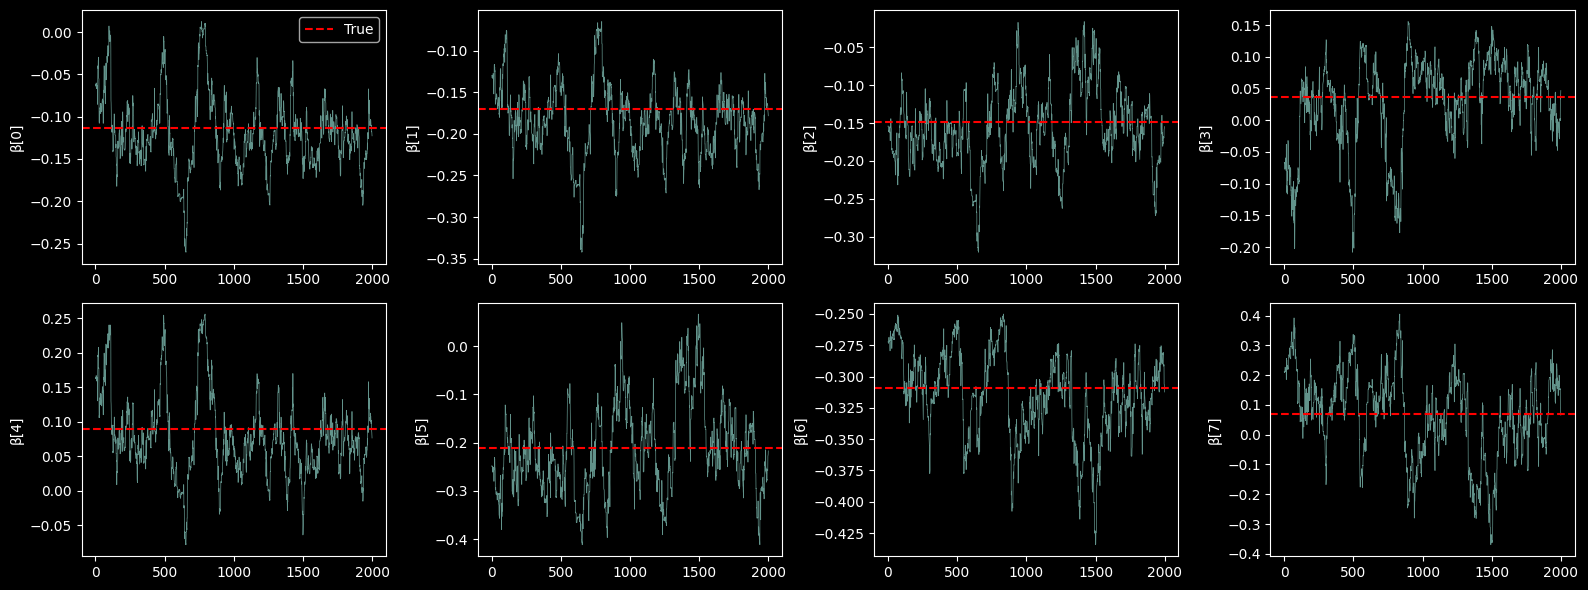

In [24]:
# Trace plots
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
for i in range(problem.BETA_SIZE):
    ax = axes[i // 4, i % 4]
    ax.plot(np.array(beta_samples[:, i]), alpha=0.7, lw=0.5)
    ax.axhline(float(beta_true[i]), c='r', ls='--', label='True')
    ax.set_ylabel(f'β[{i}]')
    if i == 0: ax.legend()
plt.tight_layout()
plt.show()

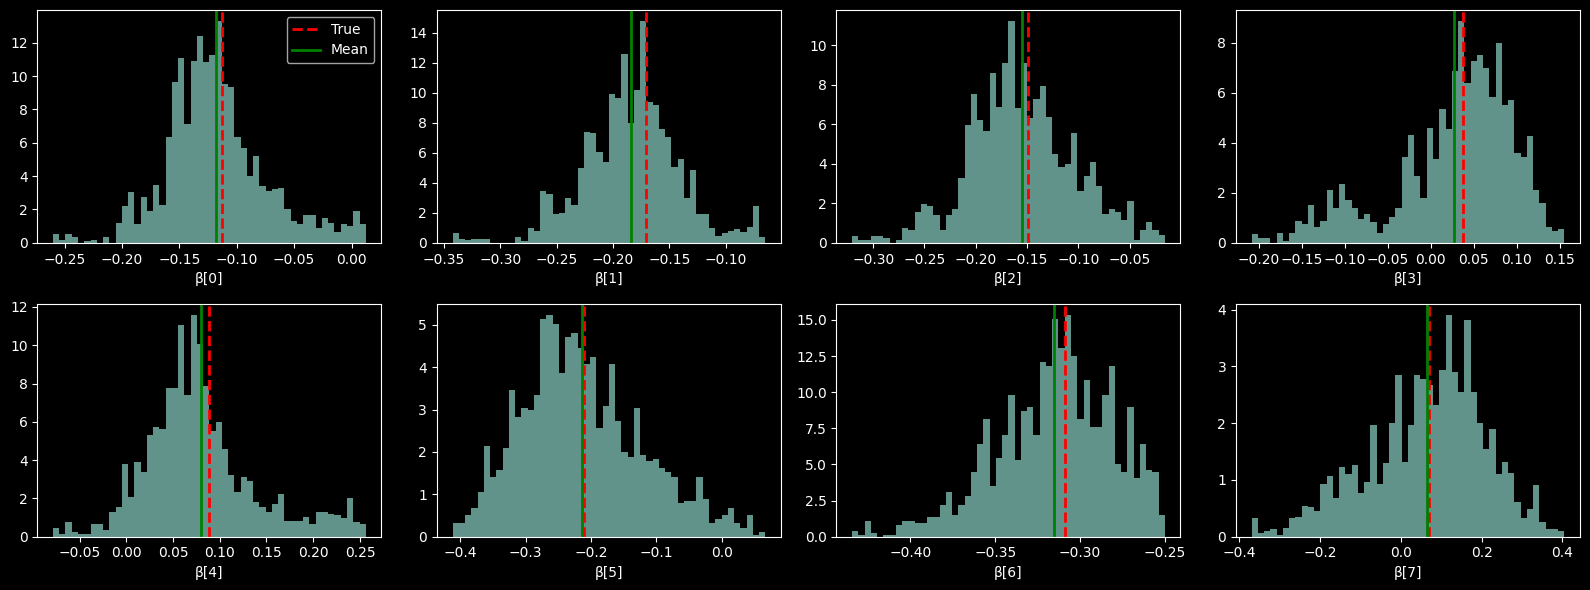

In [25]:
# Posterior histograms
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
for i in range(problem.BETA_SIZE):
    ax = axes[i // 4, i % 4]
    ax.hist(np.array(beta_samples[:, i]), bins=50, density=True, alpha=0.7)
    ax.axvline(float(beta_true[i]), c='r', ls='--', lw=2, label='True')
    ax.axvline(float(beta_samples[:, i].mean()), c='g', lw=2, label='Mean')
    ax.set_xlabel(f'β[{i}]')
    if i == 0: ax.legend()
plt.tight_layout()
plt.show()

## 9. Decode to Coefficient Fields

In [26]:
# Decode all samples
n_samples = beta_samples.shape[0]
x_tiled = jnp.tile(x_full, (n_samples, 1, 1))

# Coefficient
a_pred_all = problem.models['a'].apply({'params': params['a']}, x_tiled, beta_samples)
a_pred_all = a_pred_all[..., None]

# Solution
u_pred_all = problem.models['u'].apply({'params': params['u']}, x_tiled, beta_samples)
if u_pred_all.ndim == 2:
    u_pred_all = u_pred_all[..., None]
u_pred_all = mollifier(u_pred_all.squeeze(-1), x_tiled)

print(f"a_pred_all: {a_pred_all.shape}")
print(f"u_pred_all: {u_pred_all.shape}")

a_pred_all: (2000, 841, 1)
u_pred_all: (2000, 841, 1)


In [27]:
# Posterior statistics
a_mean = jnp.mean(a_pred_all, axis=0)
a_std = jnp.std(a_pred_all, axis=0)
u_mean = jnp.mean(u_pred_all, axis=0)
u_std = jnp.std(u_pred_all, axis=0)

# Errors
a_err = float(jnp.linalg.norm(a_mean - a_true[0]) / jnp.linalg.norm(a_true[0]))
u_err = float(jnp.linalg.norm(u_mean - u_true[0]) / jnp.linalg.norm(u_true[0]))

print(f"Coefficient error: {a_err:.4f}")
print(f"Solution error: {u_err:.4f}")

Coefficient error: 0.0050
Solution error: 0.0185


## 10. Visualization

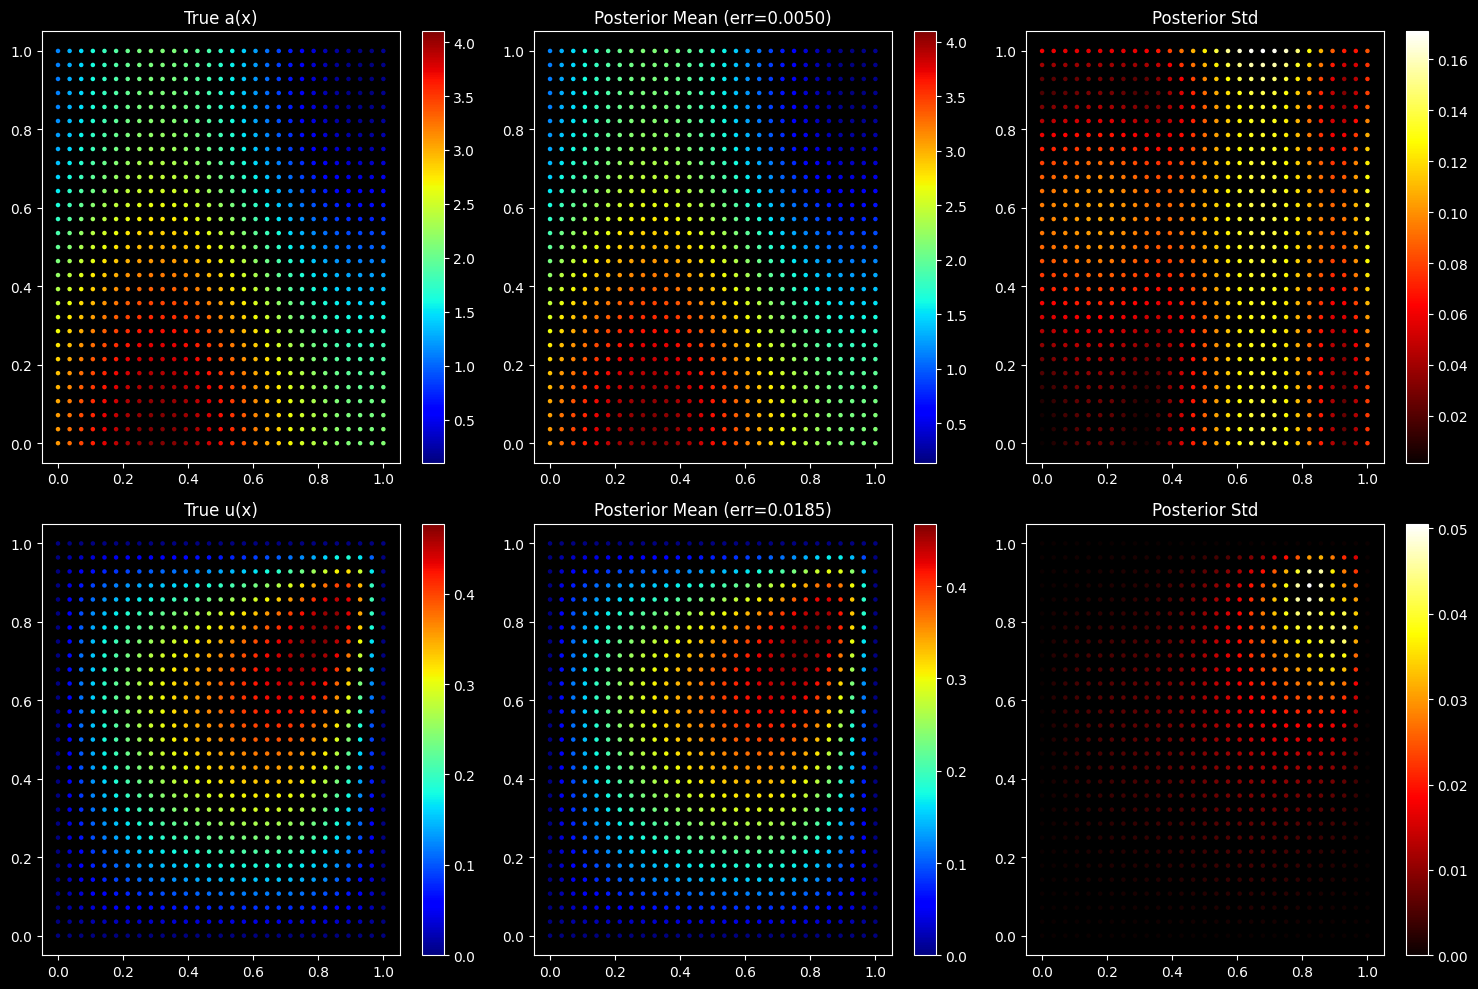

In [28]:
x_np = np.array(x_full[0])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Coefficient row
ax = axes[0, 0]
sc = ax.scatter(x_np[:, 0], x_np[:, 1], c=np.array(a_true[0, :, 0]), cmap='jet', s=5)
plt.colorbar(sc, ax=ax); ax.set_title('True a(x)')

ax = axes[0, 1]
sc = ax.scatter(x_np[:, 0], x_np[:, 1], c=np.array(a_mean[:, 0]), cmap='jet', s=5)
plt.colorbar(sc, ax=ax); ax.set_title(f'Posterior Mean (err={a_err:.4f})')

ax = axes[0, 2]
sc = ax.scatter(x_np[:, 0], x_np[:, 1], c=np.array(a_std[:, 0]), cmap='hot', s=5)
plt.colorbar(sc, ax=ax); ax.set_title('Posterior Std')

# Solution row
ax = axes[1, 0]
sc = ax.scatter(x_np[:, 0], x_np[:, 1], c=np.array(u_true[0, :, 0]), cmap='jet', s=5)
plt.colorbar(sc, ax=ax); ax.set_title('True u(x)')

ax = axes[1, 1]
sc = ax.scatter(x_np[:, 0], x_np[:, 1], c=np.array(u_mean[:, 0]), cmap='jet', s=5)
plt.colorbar(sc, ax=ax); ax.set_title(f'Posterior Mean (err={u_err:.4f})')

ax = axes[1, 2]
sc = ax.scatter(x_np[:, 0], x_np[:, 1], c=np.array(u_std[:, 0]), cmap='hot', s=5)
plt.colorbar(sc, ax=ax); ax.set_title('Posterior Std')

plt.tight_layout()
plt.show()

## 11. Coverage Analysis

In [29]:
# 95% credible intervals
a_lo = jnp.percentile(a_pred_all, 2.5, axis=0)
a_hi = jnp.percentile(a_pred_all, 97.5, axis=0)

# Coverage
in_ci = (a_true[0] >= a_lo) & (a_true[0] <= a_hi)
coverage = float(in_ci.mean())

print(f"95% CI Coverage: {coverage:.2%}")
print(f"Ideal: 95%")
if coverage < 0.9:
    print("→ Under-coverage: uncertainty is underestimated")
elif coverage > 0.99:
    print("→ Over-coverage: uncertainty is overestimated")
else:
    print("→ Well calibrated!")

95% CI Coverage: 99.88%
Ideal: 95%
→ Over-coverage: uncertainty is overestimated


## 12. Sample Gallery

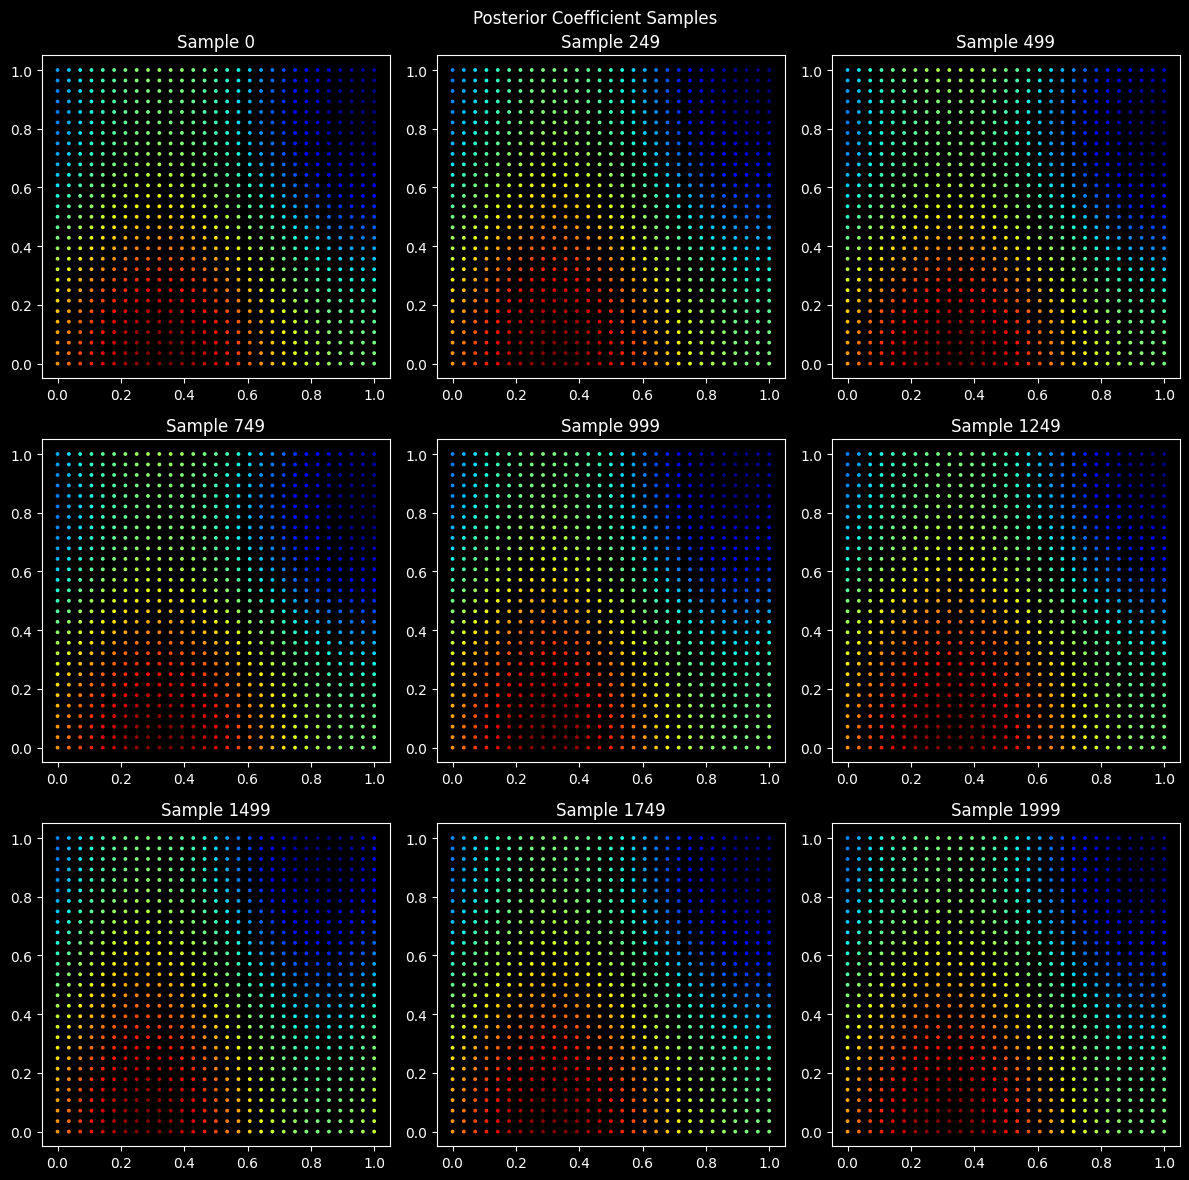

In [30]:
# Show posterior samples
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
idxs = np.linspace(0, n_samples-1, 9, dtype=int)

vmin, vmax = float(a_true[0].min()), float(a_true[0].max())

for i, idx in enumerate(idxs):
    ax = axes[i // 3, i % 3]
    sc = ax.scatter(x_np[:, 0], x_np[:, 1], c=np.array(a_pred_all[idx, :, 0]), 
                    cmap='jet', s=3, vmin=vmin, vmax=vmax)
    ax.set_title(f'Sample {idx}')

plt.suptitle('Posterior Coefficient Samples')
plt.tight_layout()
plt.show()